In [156]:
# Skip cell (weird vscode bug)

In [157]:
%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from pygem_eb.processing.plotting_fxns import *
from objectives import *
import copy
import pygem_eb.processing.gridsearch_processing as gsproc
import pygem_eb.processing.gridsearch_plotting as gsplot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [158]:
# ===== GET RESULTS DICT =====
# gsproc.process_runs('long', all=True, sites = ['AU'])             # This function re-creates each individual run .pkl and thus takes ~40 minutes
result_dict = gsproc.get_result_dict(force_redo=True)              # Add force_redo=True to recompile the result dictionaries
result_dict = gsproc.add_normalized(result_dict)    # Normalizes by calibration data; add subset=None to normalize on overall error

In [159]:
# ===== DEFINE LIST OF ERRORS TO PERFORM CALIBRATION =====
error_list = ['summer','winter','snowdensity','snowdepth']

In [160]:
# with open('../MB_data/pits.pkl', 'rb') as file:
#     site_profiles = pickle.load(file)
# site_profiles['B']['density'].pop(2012)
# site_profiles['B']['sbd'].pop(2012)
# site_profiles['B']['date'].pop(2012)
# with open('../MB_data/pits.pkl', 'wb') as file:
#     pickle.dump(site_profiles, file)

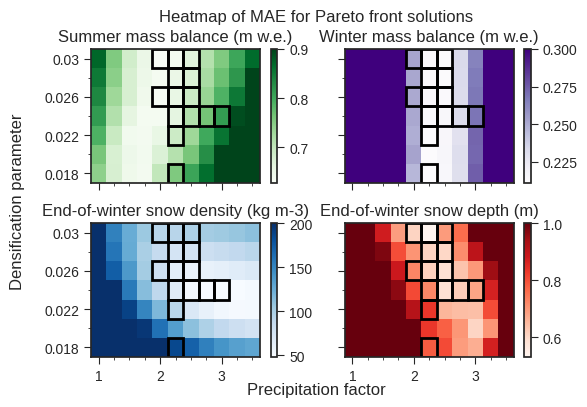

In [169]:
# ===== PARETO FRONTS ======
get_pareto_fronts = True
plot_pareto_fronts = True
metric = 'MAE'

if get_pareto_fronts:
    # Retrieve all pareto fronts
    all_pareto_fronts = gsplot.get_pareto_fronts(error_list,result_dict,plot=False)
    all_pareto_fronts_flat = list(set(list(itertools.chain(*all_pareto_fronts))))
    
    # Extract all kps and c5s
    all_pareto_kp = np.sort(list(set([front[1] for front in all_pareto_fronts_flat])))
    all_pareto_c5 = np.sort(list(set([front[0] for front in all_pareto_fronts_flat]))).astype(str).tolist()

    # Determine which parameters are consistent across all comparisons
    sets_of_tuples = [set(sublist) for sublist in all_pareto_fronts]
    consistent_parameters = set.intersection(*sets_of_tuples)

if plot_pareto_fronts:
    # gsplot.get_pareto_fronts(error_list,result_dict,plot=True,colored_param='c5')
    # gsplot.get_pareto_fronts(error_list,result_dict,plot=True,colored_param='kp')
    # gsplot.plot_pareto_PMF(error_list,all_pareto_fronts_flat,result_dict,metric+'_valid')
    # gsplot.plot_pareto_params(all_pareto_fronts_flat)
    gsplot.plot_pareto_heatmap(all_pareto_fronts_flat, result_dict, error_list, metric=metric, savefig=True)

In [162]:
# dslist = []
# for c5 in ['0.018','0.02','0.022']:
#     ds = gsproc.get_any(c5, '2.25', 'AU', result_dict)
#     print(result_dict[c5]['2.25']['AU']['winter_ME'])
#     # visualize_layers(ds, pd.date_range('2012-08-01','2013-04-20'), ['layerrefreeze'])
#     dslist.append(ds)
# compare_runs(dslist, ['2012-08-01','2013-04-20'], ['18','2','22'],'melt')
# compare_runs(dslist, ['2012-08-01','2013-04-20'], ['18','2','22'],'accum')

# compare_runs(dslist, ['2012-08-01','2013-04-20'], ['18','2','22'],'refreeze')
# compare_runs(dslist, ['2012-08-01','2013-04-20'], ['18','2','22'],'MB')

# #     years, winter, meas, _,_,_,_ = seasonal_mass_balance(ds, out='data')
# #     plt.plot(years[1:], np.array(winter - meas.values)[1:], label=c5)
# #     print(np.mean(np.abs(np.array(winter - meas.values)[1:])))
# # plt.legend()
# # plt.show()

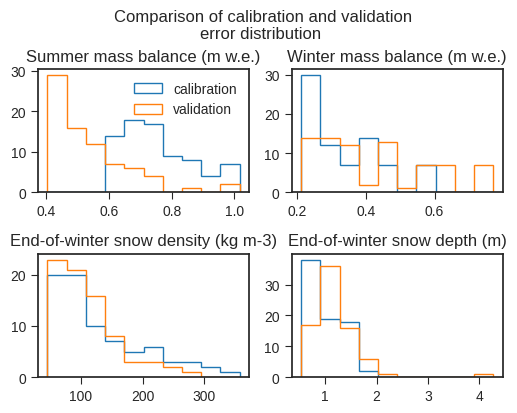

In [163]:
# ===== COMPARE VALIDATION TO CALIBRATION =====
gsplot.compare_calib_valid(error_list, result_dict) #, pareto_fronts = all_pareto_fronts_flat)

In [164]:
# ===== WEIGHT PARAMETERS AND FIND BEST =====
best_by = gsproc.get_best(error_list, result_dict, prints=True, site='median')
best = best_by[-1]

Weights:
    summer     winter snowdensity  snowdepth     best
         1          0          0          0      ('0.028', '2')
         0          1          0          0      ('0.018', '2.25')
         0          0          1          0      ('0.024', '3.25')
         0          0          0          1      ('0.024', '2.5')
      0.25       0.25       0.25       0.25      ('0.024', '2.5')


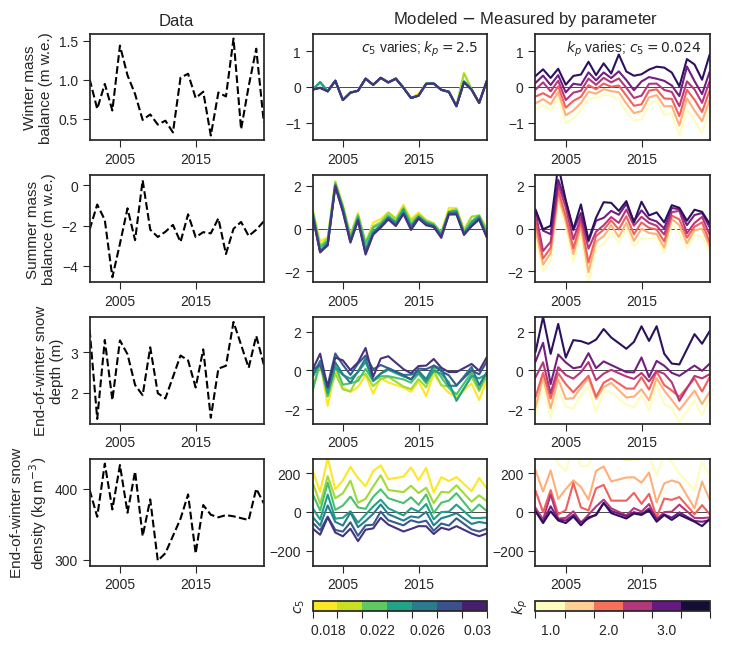

In [165]:
# ===== TRADEOFFS TIMESERIES=====
# WARNING: this function takes ~90 seconds to run!
gsplot.plot_difference_by_param(best, result_dict, plot_vars=['winter','summer','snowdepth','snowdensity'], savefig=True)

In [9]:
# ===== TRADEOFFS TIMESERIES FOR ONE RUN TYPE =====
# gsplot.plot_tradeoffs_2024(result_dict, best_by[-1])
# gsplot.plot_tradeoffs_annual(result_dict, best_by[-1])
# gsplot.plot_tradeoffs_snowpits(result_dict, best_by[-1])

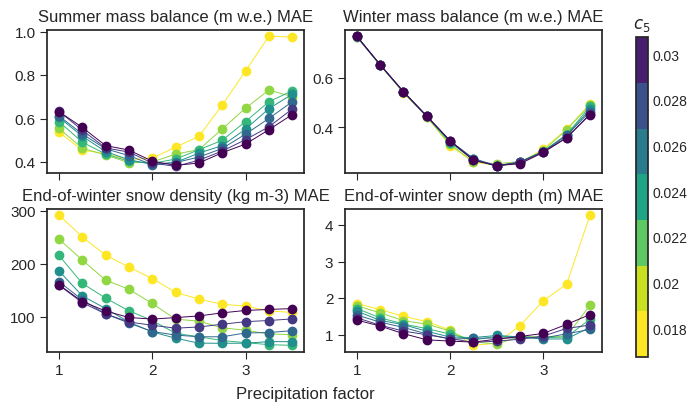

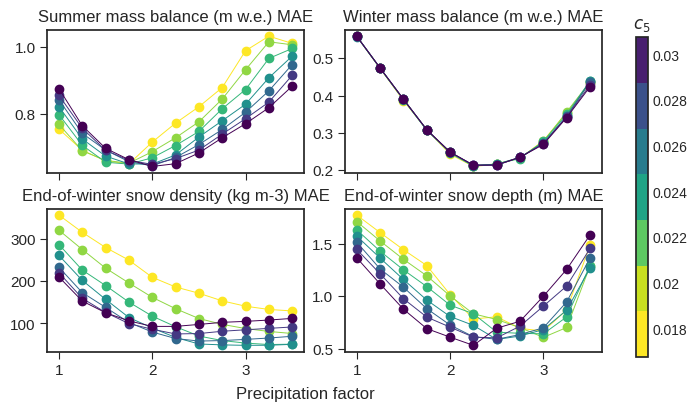

In [21]:
# ===== MULTI-PANEL TRADEOFFS =====
gsplot.plot_tradeoffs(result_dict,error_list,savefig=True,subset='valid')
gsplot.plot_tradeoffs(result_dict,error_list,savefig=True,subset='calib')

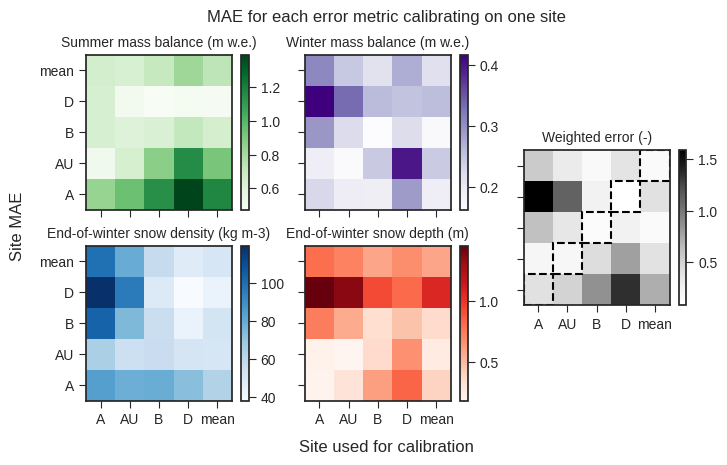

In [22]:
# ===== CALIBRATE ON ONE SITE =====
# gsplot.plot_best_by_site(error_list, result_dict)
gsplot.plot_heatmap_by_site(error_list, result_dict, metric='MAE', savefig=True)

In [28]:
all_MAE = []
for site in ['AB','ABB','B','BD','D']: #,'T']:
    ds = gsproc.get_any(best[0],best[1],site,result_dict,'2024')
    all_MAE.append(cumulative_mass_balance(ds))
# mbmod,mbmeas = cumulative_mass_balance(ds,out='mbs')
# mbmod-mbmeas
print(np.mean(all_MAE))

0.2740343317431583


Site AB internal acc: 0.00008 m w.e.
Site B internal acc: 0.00002 m w.e.
Site D internal acc: 0.07641 m w.e.
Site T internal acc: 0.08583 m w.e.


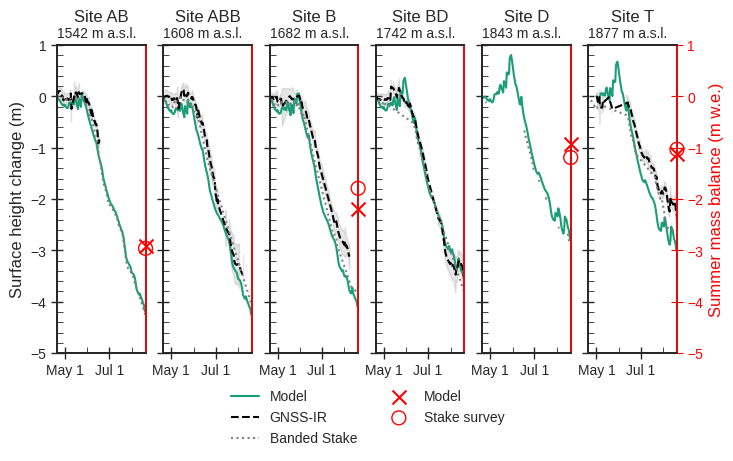

In [ ]:
# ===== PLOT A SINGLE RUN =====
gsplot.plot_best_seasonal(best_by[-1], result_dict)
# gsplot.plot_best_2024(best_by[-1], result_dict)
# gsplot.plot_best_snowpits(best_by[-1], result_dict)
# gsplot.plot_best_snowmass(best_by[-1], result_dict) 
# gsplot.plot_best_albedo(best_by[-1], result_dict)

In [36]:
print(result_dict[best[0]][best[1]]['B']['summer_MAE_calib'])

0.6012067969784881


Troubleshooting weird wnter runs

In [35]:
# ds = gsproc.get_any('0.03','2.5','B',result_dict)
# years, base,_,  _,_,_,_ = seasonal_mass_balance(ds, out='data')
# fig,axes = plt.subplots(3,2, sharey=True)
# axes = axes.flatten()
# i = 0
# for c5 in ['0.018','0.02','0.022','0.024','0.026','0.028']:
#     ds = gsproc.get_any(c5,'2.5','B',result_dict)
#     # normal = gsproc.get_any('0.022','2.5','B',result_dict)
#     years, wmod, wmeas,  _,_,_,_ = seasonal_mass_balance(ds, out='data')
#     axes[i].plot(years, wmod - base)
#     axes[i].set_title(c5)
#     i += 1
# plt.legend()
# plt.show()
# dates = pd.date_range('2001-04-01','2002-04-01')
# visualize_layers(weird, dates, ['layertemp'])
# visualize_layers(normal, dates, ['layertemp'])

In [ ]:
fig, axes = plt.subplots(2,figsize=(6,5),gridspec_kw={'hspace':0.1},sharex=True)
list_plots = []
sites = ['A','AU','B','D']
colors = np.flip(['#F0E442','#E69F00','#009E73','#0072B2']) #

for ss,site in enumerate(sites):   
    ds,s,e = getds('.nc')

    color = colors[ss]
    axes[0] = plot_seasonal_mass_balance(ds,plot_ax=axes[0],plot_var='bw',color=color)
    axes[1] = plot_seasonal_mass_balance(ds,plot_ax=axes[1],plot_var='bs',color=color)
    dummy_site, = axes[1].plot(np.nan,np.nan,color=color)
    list_plots.append(dummy_site)
dummy_model, = axes[1].plot(np.nan,np.nan,color='gray')
dummy_meas, = axes[1].plot(np.nan,np.nan,color='gray',linestyle='--')
list_plots.append(dummy_model)
list_plots.append(dummy_meas)
axes[0].set_ylabel('Winter',fontsize=12)
axes[1].set_ylabel('Summer',fontsize=12)
axes[0].set_ylim(-0.5,2.5)
axes[1].set_ylim(-7,1)
axes[1].set_yticks([0,-2,-4,-6])
for i in range(2):
    axes[i].get_legend().remove()
labels = ['Site '+sss for sss in sites]+['Modeled','Measured']
fig.legend(list_plots,labels,bbox_to_anchor=(1.12,0.8),fontsize=10)
fig.suptitle('Seasonal mass balance (m w.e.)',fontsize=12,y=0.96)
plt.show()

# Below are functions I probably don't need but don't want to delete yet

ELEVATION DEPENDENCE

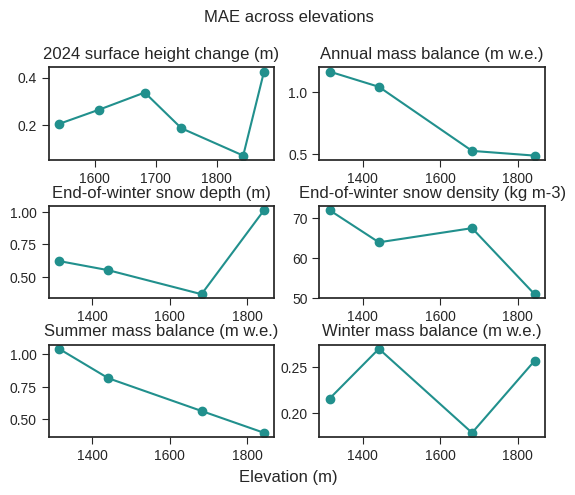

In [25]:
fig,axes = plt.subplots(3,2, gridspec_kw={'hspace':0.5, 'wspace':0.2})
axes = axes.flatten()
metric = 'MAE'
markers = ['o','^','*','x','+','>','v','s','D','2','4']
all_c5s = [float(x[0]) for x in all_pareto_fronts_flat]
norm = mpl.colors.Normalize(vmin=np.min(all_c5s),vmax=np.max(all_c5s))
cmap = mpl.colormaps.get_cmap('viridis_r')
for e,error_name in enumerate(['2024','annual','snowdepth','snowdensity','summer','winter']):
    run = '2024' if '2024' in error_name else 'long'
    date = run_info[run]['date']
    idx = run_info[run]['idx']
    
    for front in [best]: # all_pareto_fronts_flat:
        c5, kp = front
        kp = kp.replace('.0','')
        index_marker = params['kp'].index(kp)
        list_error = []
        list_elev = []
        for site in sitedict[run]:
            # Get elevation of the site
            df = pd.read_csv('~/research/PyGEM-EB/data/Gulkana/site_constants.csv',index_col='site')
            elevation = df.loc[site,'elevation']
            list_error.append(result_dict[c5][kp][site][error_name + '_' + metric])
            list_elev.append(elevation)
        axes[e].plot(list_elev, list_error, color=cmap(norm(float(c5))), marker=markers[0])
    axes[e].set_title(errorlabels[error_name])
    axes[e].tick_params(length=5)
fig.supxlabel('Elevation (m)')
fig.suptitle('MAE across elevations',y=1)
plt.show()

Snowpack ripening

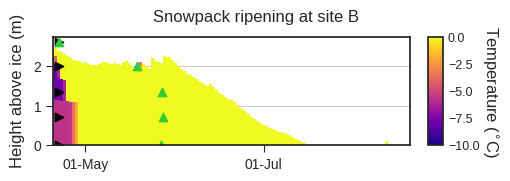

In [34]:
ripe_dict = {'AU': {10: pd.Timestamp('2024-04-21 22:45:00'), 40: pd.Timestamp('2024-04-26 05:30:00'), 80: pd.Timestamp('2024-05-01 14:30:00'), 150: pd.Timestamp('2024-04-27 14:30:00')}, 'B': {10: pd.Timestamp('2024-04-21 21:15:00'), 70: pd.Timestamp('2024-05-18 20:15:00'), 135: pd.Timestamp('2024-05-27 08:45:00'), 200: pd.Timestamp('2024-05-27 11:30:00'), 270: pd.Timestamp('2024-05-26 18:30:00')}, 'D': {10: pd.Timestamp('2024-06-01 18:00:00'), 40: pd.Timestamp('2024-06-02 14:15:00'), 80: pd.Timestamp('2024-06-02 16:45:00'), 120: pd.Timestamp('2024-06-05 14:00:00'), 150: pd.Timestamp('2024-06-05 08:45:00')}}
site = 'B'
ripe_dates = {}
# if site == 'AU':
#     ds,s,e = getds(f'~/research/Output/EB/Gulkana_2025_01_29_0.nc')
# else:
#     ds,s,e = getds(f'~/research/Output/EB/Gulkana_01_29_2024{site}_0.nc')
ds = gsproc.get_any('0.022','2.5',site,result_dict,'2024')

if site =='D':
    fig,ax = visualize_layers(ds,pd.date_range('2024-04-20','2024-08-20'),['layertemp']) #,plot_firn=False)
else:
    fig,ax = visualize_layers(ds,pd.date_range('2024-04-20','2024-08-20'),['layertemp'])
# Scatter initial heights of iButtons
depths = np.array([f for f in ripe_dict[site]])
heights = depths[-1] - depths
start = np.array([pd.to_datetime('2024-04-22') for _ in range(len(heights))])
if site == 'D':
    heights += 700
ax.scatter(start,heights/100,color='black',marker='>',label='iButtons buried')

# Scatter ripened dates for each sensor
for depth in ripe_dict[site]:
    if site != 'B':
        height = 150 - depth
    else:
        height = 270 - depth
    if site == 'D':
        height += 700
    ax.scatter(ripe_dict[site][depth],height/100,marker='^',color='limegreen')
ax.scatter(np.nan,np.nan,marker='^',color='limegreen',label='iButtons ripe')
fig.suptitle('Snowpack ripening at site '+site)
plt.show()

Generate pits pickle

In [ ]:
site_profiles = {}
fp ='/trace/home/cvwilson/research/MB_data/Point/gulkana/pitcore/'
all_pits = os.listdir(fp)
for site in ['A','AU','B','D']:
    site_profiles[site] = {'sbd':{},'density':{},'date':{}}
    years= []
    dates = []
    density = []
    for f in all_pits:
        if '_' + site + '.' in f:
            try:
                df = pd.read_csv(fp+f)
            except:
                print('failed to read',fp+f)
                continue
            year = f.split('_')[1]
            try:
                int(year)
            except:
                year = f.split('Gulkana')[1][:4]
            if int(year) > 1999:
                date = f.split(str(year))[1][1:6].replace('.','-').replace('_','-')+'-'
                if '05' in date or '04' in date:
                    sbd = df['sample_bottom_depth']
                    density = df['sample_weight'] / df['volume']
                    site_profiles[site]['sbd'][int(year)] = sbd.values / 100
                    site_profiles[site]['density'][int(year)] = density.values
                    site_profiles[site]['date'][int(year)] = date
                    if year == '2012' and site == 'B':
                        print(f, density)

    for year in site_profiles[site]['sbd']:
        plt.plot(site_profiles[site]['density'][year],site_profiles[site]['sbd'][year], label=year)
    
#     plt.ylim(0)
#     plt.gca().invert_yaxis()
#     plt.title(site)
#     plt.legend()
#     plt.show()
# print(site_profiles)